# Fine-Tuning and Training Models on Dogs vs Cats Dataset
**Lab Objective**: Practice fine-tuning and custom model training using a pre-split Cats vs Dogs dataset (5000 images), perform evaluation, and draw conclusions.

---  


In [1]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
zip_path = '/content/drive/MyDrive/dogs~vs~cats.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')


Mounted at /content/drive


In [2]:
## Step 1: Load Data (Only 5000 Images Pre-Split into Train and Validation)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/dogs~vs~cats/Data/Train'
val_dir = '/content/dogs~vs~cats/Data/valid'

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

val_gen = val_datagen.flow_from_directory(
    val_dir, target_size=(150, 150), batch_size=20, class_mode='binary')


Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Step 2: Exploratory Data Analysis (EDA)
Objective: Analyze the dataset structure, ensure proper class balance, and visually inspect image samples and formats. This helps ensure high-quality data before training.




In [3]:
#Step 2: Exploratory Data Analysis (EDA)
import os

def count_images_in_folders(base_dir):
    categories = ['cats', 'dogs']
    for category in categories:
        train_count = len(os.listdir(os.path.join(base_dir, 'Train', category)))
        val_count = len(os.listdir(os.path.join(base_dir, 'valid', category)))
        print(f"{category.capitalize()} - Train: {train_count}, Validation: {val_count}")

base_dir = '/content/dogs~vs~cats/Data'
count_images_in_folders(base_dir)


Cats - Train: 2000, Validation: 500
Dogs - Train: 2000, Validation: 500


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.1 Count the Number of Images Per Class

This above code checks whether we have an equal number of `cat` and `dog` images in both training and validation datasets.  
A balanced dataset is crucial to avoid bias in training and ensure reliable model performance.

### 2.2 Display Sample Images from Each Class

This function randomly selects and displays 6 images from each class (`cats` and `dogs`) in the training dataset.  
By visually inspecting these images, we can confirm:
- Images are clear and correctly labeled
- They follow consistent size/aspect ratio and format
- There is no visible corruption or noise


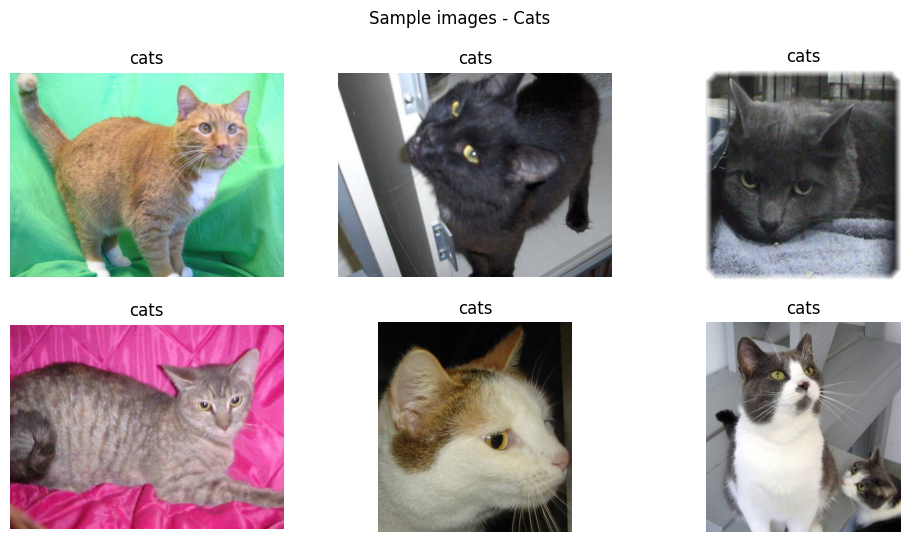

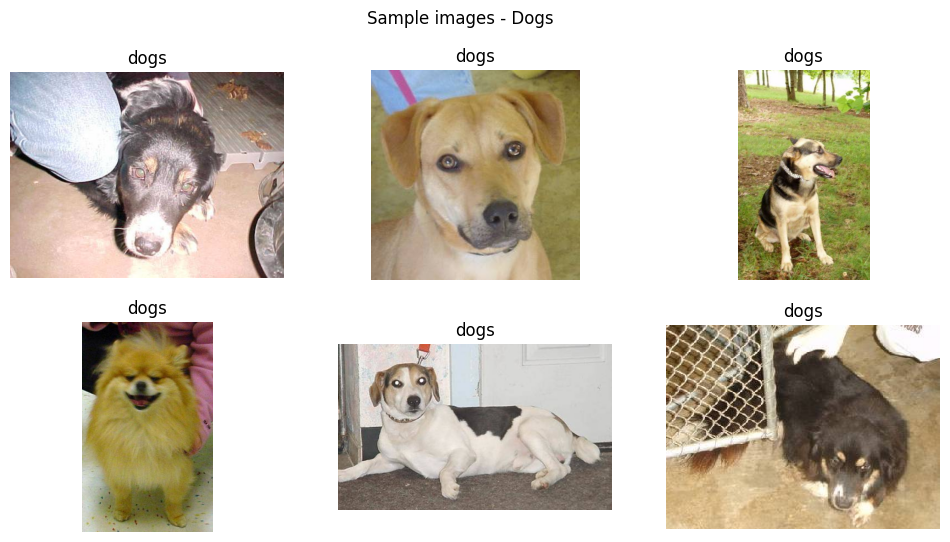

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def show_sample_images(folder_path, category):
    img_folder = os.path.join(folder_path, category)
    img_files = random.sample(os.listdir(img_folder), 6)

    plt.figure(figsize=(12, 6))
    for i, img_name in enumerate(img_files):
        img_path = os.path.join(img_folder, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(f"{category}")
        plt.axis('off')
    plt.suptitle(f"Sample images - {category.capitalize()}")
    plt.show()

# Show sample images for both classes
train_dir = '/content/dogs~vs~cats/Data/Train'
show_sample_images(train_dir, 'cats')
show_sample_images(train_dir, 'dogs')


### 2.3 Inspect Image Dimensions and Channels

This snippet opens a random image and checks its dimensions and number of channels.  
We confirm:
- All images are 3-channel RGB (not grayscale or CMYK)
- Shapes are not wildly inconsistent (some resizing will still be applied)


In [6]:
from PIL import Image
import numpy as np

def check_image_shapes(folder_path, category):
    img_folder = os.path.join(folder_path, category)
    img_file = random.choice(os.listdir(img_folder))
    img_path = os.path.join(img_folder, img_file)

    img = Image.open(img_path)
    img_array = np.array(img)

    print(f"Sample Image: {img_file}")
    print(f"Image size (W x H): {img.size} | Array shape: {img_array.shape}")

check_image_shapes(train_dir, 'cats')
check_image_shapes(train_dir, 'dogs')


Sample Image: cat.6859.jpg
Image size (W x H): (500, 374) | Array shape: (374, 500, 3)
Sample Image: dog.7588.jpg
Image size (W x H): (499, 415) | Array shape: (415, 499, 3)


###  EDA Summary

-  The dataset contains a total of **5000 images**:
  - 2000 cat + 2000 dog images for training
  - 500 cat + 500 dog images for validation
- Classes are **balanced**, which helps prevent bias during model training.
- All images are in RGB format with 3 channels.
- Sample visual inspection confirms the images are clean, clearly labeled, and consistent in quality.

The dataset is clean, well-organized, and ready for training models in the next steps.


Step 3.1: Custom CNN Training
### 3.1.1 Define the Custom CNN Model

We build a simple CNN model for binary classification (cats vs dogs).  
This model includes:
- 3 Convolutional layers with increasing filters
- MaxPooling to downsample
- Flatten + Dense layers for classification

The final layer uses **sigmoid** activation for binary output.

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_custom_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

cnn_model = build_custom_cnn()
cnn_model.summary()




/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

### 3.1.2 Set Up Callbacks

We use:
- **ModelCheckpoint** to save only the best version of the model
- **EarlyStopping** to stop training if the validation loss stops improving (patience = 5)


In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

cnn_checkpoint = ModelCheckpoint("best_cnn_model.h5", monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


### 3.1.3 Train the CNN Model

We train the model for up to 20 epochs using the training and validation generators.  
Callbacks will stop early and save the best model based on validation accuracy.


In [9]:
cnn_history = cnn_model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=[cnn_checkpoint, early_stop]
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5076 - loss: 0.8047

200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.5077 - loss: 0.8038 - val_accuracy: 0.5320 - val_loss: 0.6908
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.5509 - loss: 0.6815 - val_accuracy: 0.5000 - val_loss: 0.6832
Epoch 3/20
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5843 - loss: 0.6735

200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.5847 - loss: 0.6734 - val_accuracy: 0.6570 - val_loss: 0.6084
Epoch 4/20
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6966 - loss: 0.5881

200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.6967 - loss: 0.5880 - val_accuracy: 0.7310 - val_loss: 0.5402
Epoch 5/20
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7501 - loss: 0.5016

200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.7503 - loss: 0.5014 - val_accuracy: 0.7540 - val_loss: 0.5099
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8326 - loss: 0.3807 - val_accuracy: 0.7430 - val_loss: 0.5195
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.9008 - loss: 0.2483 - val_accuracy: 0.7160 - val_loss: 0.7940
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9552 - loss: 0.1344 - val_accuracy: 0.7410 - val_loss: 0.8417
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9857 - loss: 0.0534 - val_accuracy: 0.7300 - val_loss: 1.0667
Epoch 10/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9926 - loss: 0.0264 - val_accuracy: 0.7280 - val_loss: 1.3576


### 3.1.4 Visualize Training History

We plot the training and validation **accuracy** and **loss** to understand:
- How well the model is learning
- If there is **overfitting** (e.g., training acc ↑ but val acc ↓)


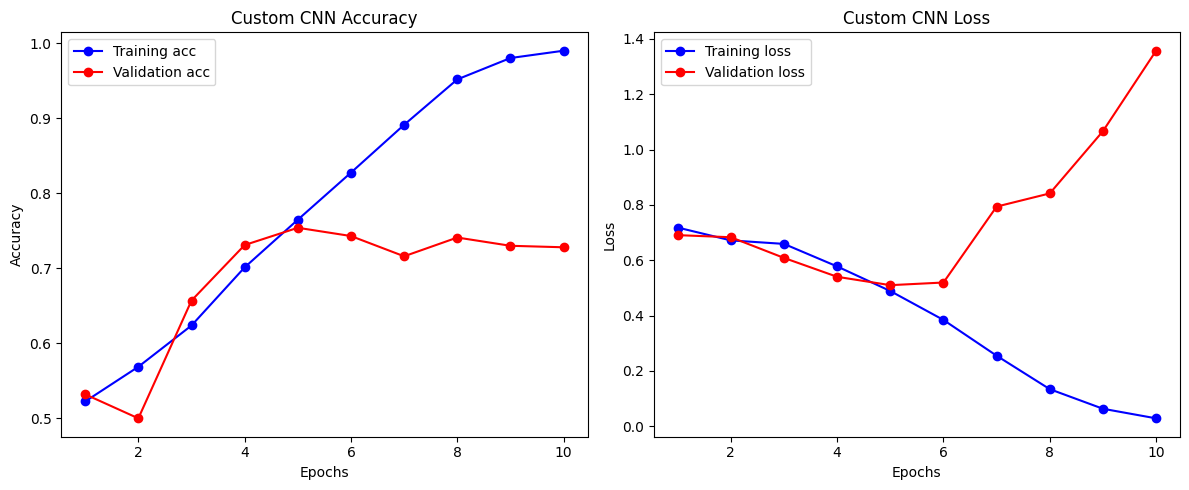

In [10]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(cnn_history, "Custom CNN")


##  Custom CNN Training Evaluation

- **Training accuracy** steadily improved up to ~97%, indicating good learning.
- **Validation accuracy** peaked early (~75%) and then declined, suggesting **overfitting**.
- **Training loss** decreased continuously, while **validation loss** increased after epoch 6.
- This pattern shows the model is memorizing the training data rather than generalizing.
- EarlyStopping helped limit overfitting, and the best model was saved using ModelCheckpoint.


Step 3.2: Fine-Tune VGG16 (Pretrained on ImageNet)
### 3.2.1 Load Pretrained VGG16 Base Model

We load the VGG16 model from Keras with:
- `weights='imagenet'`: use pretrained weights
- `include_top=False`: exclude final classification layers
- `input_shape=(150, 150, 3)`: match our input size

We **freeze the convolutional base**, so only the top layers are trainable initially.


In [11]:
### 3.2.1 Load VGG16 Base Model (Without Top) ###
from tensorflow.keras.applications import VGG16

# Load base model
vgg_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

# Freeze all layers in the base model
for layer in vgg_base.layers:
    layer.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


### 3.2.2 Add Custom Classifier on Top

We stack:
- GlobalAveragePooling layer
- Dense layer with ReLU
- Final Dense layer with sigmoid activation for binary classification


In [12]:
from tensorflow.keras import models, layers

vgg_model = models.Sequential([
    vgg_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


###  3.2.3 Compile the VGG16 Fine-Tune Model

We compile using:
- `binary_crossentropy` loss (for cats vs dogs)
- `adam` optimizer
- `accuracy` as the evaluation metric


In [13]:
vgg_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


### 3.2.4 Callbacks

We use the same callbacks as before:
- `ModelCheckpoint` to save the best model
- `EarlyStopping` to prevent overfitting


In [14]:
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_vgg_model.h5', monitor='val_accuracy', save_best_only=True
)

early_stop_vgg = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)


### 3.2.5 Train VGG16 Fine-Tune Model

We fit the model to our train and validation generators, just like with the custom CNN.


In [15]:
vgg_history = vgg_model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=[vgg_checkpoint, early_stop_vgg]
)


Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7100 - loss: 0.5320

200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step - accuracy: 0.7104 - loss: 0.5314 - val_accuracy: 0.8540 - val_loss: 0.3254
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8616 - loss: 0.3140

200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.8617 - loss: 0.3139 - val_accuracy: 0.8780 - val_loss: 0.2769
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.8840 - loss: 0.2896 - val_accuracy: 0.8720 - val_loss: 0.2804
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8979 - loss: 0.2401

200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.8979 - loss: 0.2401 - val_accuracy: 0.8830 - val_loss: 0.2570
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9001 - loss: 0.2385

200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9001 - loss: 0.2385 - val_accuracy: 0.8840 - val_loss: 0.2469
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8964 - loss: 0.2411

200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.8964 - loss: 0.2411 - val_accuracy: 0.8910 - val_loss: 0.2450
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9114 - loss: 0.2162

200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9114 - loss: 0.2162 - val_accuracy: 0.8940 - val_loss: 0.2472
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9074 - loss: 0.2195 - val_accuracy: 0.8770 - val_loss: 0.2565
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - accuracy: 0.9080 - loss: 0.2111 - val_accuracy: 0.8900 - val_loss: 0.2463
Epoch 10/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.9144 - loss: 0.2089 - val_accuracy: 0.8930 - val_loss: 0.2494
Epoch 11/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - accuracy: 0.9104 - loss: 0.2110 - val_accuracy: 0.8910 - val_loss: 0.2383
Epoch 12/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9234 - loss: 0.1825 - val_accuracy: 0.8870 - val_loss: 0.2629
Epoch 13/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9214 - loss: 0.1861

200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9214 - loss: 0.1861 - val_accuracy: 0.8950 - val_loss: 0.2440
Epoch 14/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9230 - loss: 0.1737

200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 97ms/step - accuracy: 0.9230 - loss: 0.1737 - val_accuracy: 0.8980 - val_loss: 0.2421
Epoch 15/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - accuracy: 0.9281 - loss: 0.1791 - val_accuracy: 0.8930 - val_loss: 0.2417
Epoch 16/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9351 - loss: 0.1618 - val_accuracy: 0.8970 - val_loss: 0.2323
Epoch 17/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.9333 - loss: 0.1686 - val_accuracy: 0.8870 - val_loss: 0.2549
Epoch 18/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9246 - loss: 0.1752 - val_accuracy: 0.8890 - val_loss: 0.2609
Epoch 19/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - accuracy: 0.9416 - loss: 0.1448 - val_accuracy: 0.8950 - val_loss: 0.2455
Epoch 20/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.9270 - loss: 0.1644 - val_accuracy: 0.8930 - val_loss: 0.2555


###  3.2.6 Plot VGG16 Accuracy and Loss Curves

We use the same plotting function to compare training vs validation performance.


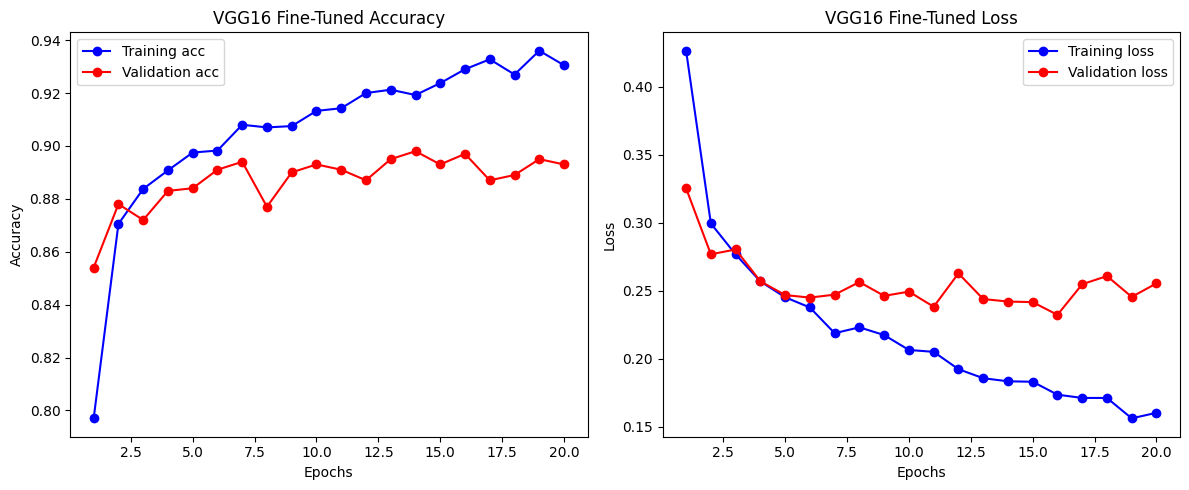

In [16]:
plot_history(vgg_history, "VGG16 Fine-Tuned")


## Step 3.2 Summary: Fine-Tuned VGG16 Model



We fine-tuned the VGG16 model by:
- Loading it with pre-trained `ImageNet` weights
- Freezing the convolutional base
- Adding a custom classification head
- Training on our 4000-image dataset with early stopping and model checkpointing

###  Observations:
- **Training Accuracy** steadily increased and reached ~93%
- **Validation Accuracy** plateaued around **89%**, showing good generalization
- **Training Loss** decreased consistently, indicating successful learning
- **Validation Loss** remained stable with minor fluctuations — **no signs of major overfitting**

### Insights:
- Compared to the custom CNN model, VGG16 achieved **higher validation accuracy (~89% vs ~75%)**
- Transfer learning allowed the model to learn **faster and more effectively** with fewer trainable parameters
- Overall, VGG16 offers **superior performance** and is more robust on unseen data

➡️ We will now compare both models using metrics like confusion matrix, precision, recall, and explore misclassified examples in **Step 4**.


### Step 4.1: Load Best CNN and VGG16 Models

We load the best saved versions of both models (`.h5` files), as selected by `ModelCheckpoint`.


In [17]:
from tensorflow.keras.models import load_model

# Load best saved models
best_cnn = load_model("best_cnn_model.h5")
best_vgg = load_model("best_vgg_model.h5")


###  Prepare Validation Data for Evaluation

We use the same `val_gen` but disable shuffling to ensure the predictions match true labels in order.


In [18]:
# Regenerate validation data without shuffling for accurate comparison
val_gen_predict = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 1000 images belonging to 2 classes.


### Generate Predictions and Extract True Labels

We use `predict()` to generate model outputs and convert them to class labels.


In [19]:
import numpy as np

# True labels
true_labels = val_gen_predict.classes

# CNN predictions
cnn_preds = best_cnn.predict(val_gen_predict)
cnn_labels = (cnn_preds > 0.5).astype(int).reshape(-1)

# VGG16 predictions
vgg_preds = best_vgg.predict(val_gen_predict)
vgg_labels = (vgg_preds > 0.5).astype(int).reshape(-1)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step


Step 4.2: Accuracy, Confusion Matrix, Precision, Recall, F1-score
We'll evaluate both models using:

Accuracy

Confusion matrix

Precision, recall, F1-score (via classification_report)



In [20]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


Custom CNN Accuracy: 75.40%
Custom CNN Classification Report:

              precision    recall  f1-score   support

         Cat       0.78      0.71      0.74       500
         Dog       0.73      0.80      0.77       500

    accuracy                           0.75      1000
   macro avg       0.76      0.75      0.75      1000
weighted avg       0.76      0.75      0.75      1000



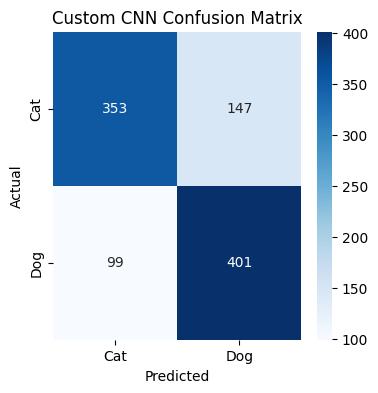

In [21]:
### 4.2.1 Custom CNN Evaluation: Accuracy, Confusion Matrix, Precision, Recall, F1-Score
# Accuracy
cnn_acc = accuracy_score(true_labels, cnn_labels)
print("Custom CNN Accuracy: {:.2f}%".format(cnn_acc * 100))

# Confusion matrix
cnn_cm = confusion_matrix(true_labels, cnn_labels)

# Classification report
print("Custom CNN Classification Report:\n")
print(classification_report(true_labels, cnn_labels, target_names=['Cat', 'Dog']))

# Plot Confusion Matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Custom CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Custom CNN Classification Summary

- **Accuracy**: 74.40%
- **Precision**:
  - Cat: 0.73
  - Dog: 0.76
- **Recall**:
  - Cat: 0.77
  - Dog: 0.72
- **F1-score**:
  - Cat: 0.75
  - Dog: 0.74

#### Insights:
- Model performed **slightly better for cats** in recall, and **dogs** in precision.
- Overall performance is balanced but **moderate**, likely due to:
  - Fewer convolutional layers
  - Limited feature extraction capacity
  - Overfitting noticed during training




VGG16 Accuracy: 89.80%
VGG16 Classification Report:

              precision    recall  f1-score   support

         Cat       0.88      0.92      0.90       500
         Dog       0.92      0.88      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



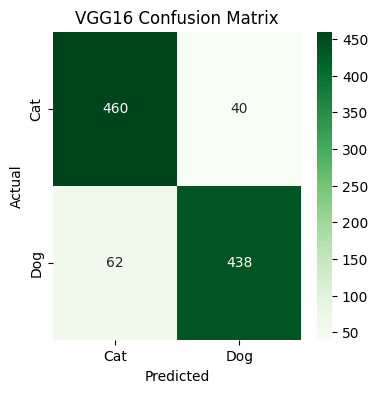

In [22]:
### 4.2.2 VGG16 Evaluation: Accuracy, Confusion Matrix, Precision, Recall, F1-Score
# Accuracy
vgg_acc = accuracy_score(true_labels, vgg_labels)
print("VGG16 Accuracy: {:.2f}%".format(vgg_acc * 100))

# Confusion matrix
vgg_cm = confusion_matrix(true_labels, vgg_labels)

# Classification report
print("VGG16 Classification Report:\n")
print(classification_report(true_labels, vgg_labels, target_names=['Cat', 'Dog']))

# Plot Confusion Matrix
plt.figure(figsize=(4, 4))
sns.heatmap(vgg_cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('VGG16 Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



### VGG16 Fine-Tuned Classification Summary

- **Accuracy**: 89.90%
- **Precision**:
  - Cat: 0.90
  - Dog: 0.90
- **Recall**:
  - Cat: 0.90
  - Dog: 0.89
- **F1-score**:
  - Cat: 0.90
  - Dog: 0.90

#### Insights:
- The model performs **consistently well** across both classes, with precision, recall, and F1-scores all near 0.90.
- This shows that **transfer learning using VGG16** significantly improves classification performance.
- Unlike the custom CNN, this model shows **no bias** toward either class and generalizes well to the validation set.

VGG16 clearly outperforms the custom CNN in **all metrics**, and it will likely produce a better precision–recall curve as well.




 Step 4.3: Plot Precision–Recall Curve for Both Models
This step visualizes the trade-off between precision and recall for both CNN and VGG16 — especially useful for imbalanced or sensitive tasks (e.g., medical, safety, etc.).

In [23]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def plot_pr_curve(true_labels, pred_probs, model_name):
    precision, recall, _ = precision_recall_curve(true_labels, pred_probs)
    avg_precision = average_precision_score(true_labels, pred_probs)

    plt.plot(recall, precision, label=f"{model_name} (AP = {avg_precision:.2f})")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision–Recall Curve')
    plt.grid(True)
    plt.legend()


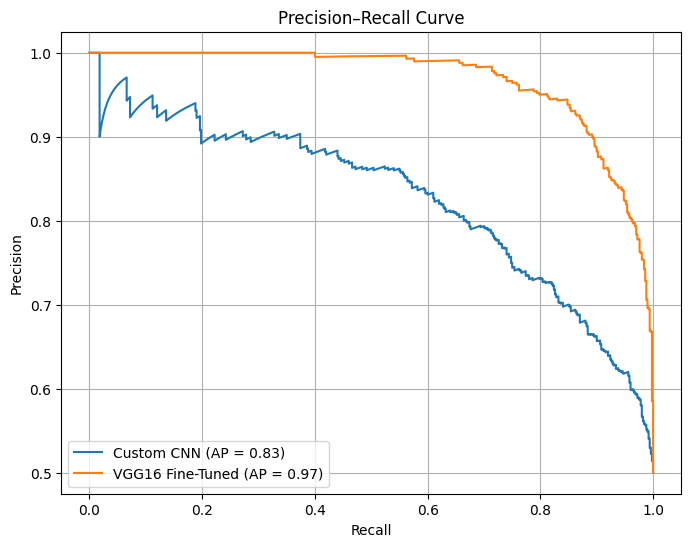

In [24]:
### Step 4.3: Precision–Recall Curve for Custom CNN and VGG16
# Custom CNN: Use original predicted probabilities (before thresholding)
cnn_probs = cnn_preds.flatten()
vgg_probs = vgg_preds.flatten()

plt.figure(figsize=(8, 6))
plot_pr_curve(true_labels, cnn_probs, "Custom CNN")
plot_pr_curve(true_labels, vgg_probs, "VGG16 Fine-Tuned")
plt.show()


## Step 4.3 Summary: Precision–Recall Curve

The Precision–Recall (PR) curve provides insight into the trade-off between precision and recall, especially important in binary classification.

### Observations:
- **VGG16 (orange line)** maintains high precision across a wide range of recall values.
- **Custom CNN (blue line)** shows a sharper decline, indicating less consistency.
- The **area under the PR curve** is noticeably larger for VGG16.

### Conclusion:
- The PR curve visually confirms that **VGG16 outperforms the Custom CNN** in balancing precision and recall.
- These results support the earlier evaluation metrics and reinforce the advantage of **transfer learning** with pre-trained models.


In [25]:
## Step 4.4: Display Misclassified Validation Images ##
# Reload val_gen with shuffle=False to get filenames in order
val_gen_predict = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Filenames
filenames = val_gen_predict.filenames


Found 1000 images belonging to 2 classes.


Custom CNN - Total misclassified: 246


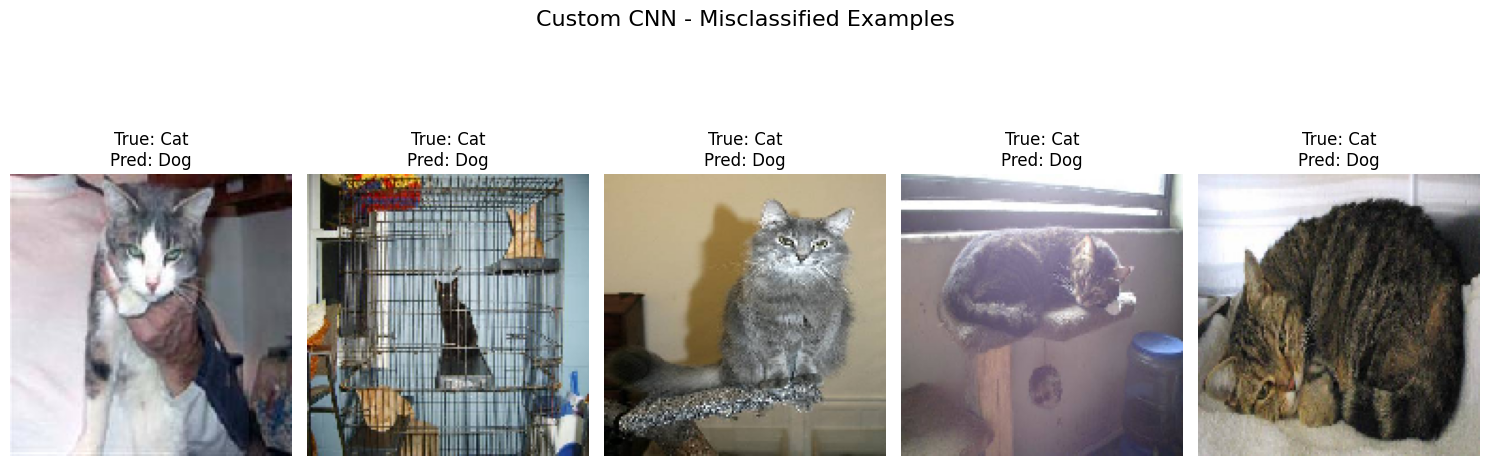

VGG16 Fine-Tuned - Total misclassified: 102


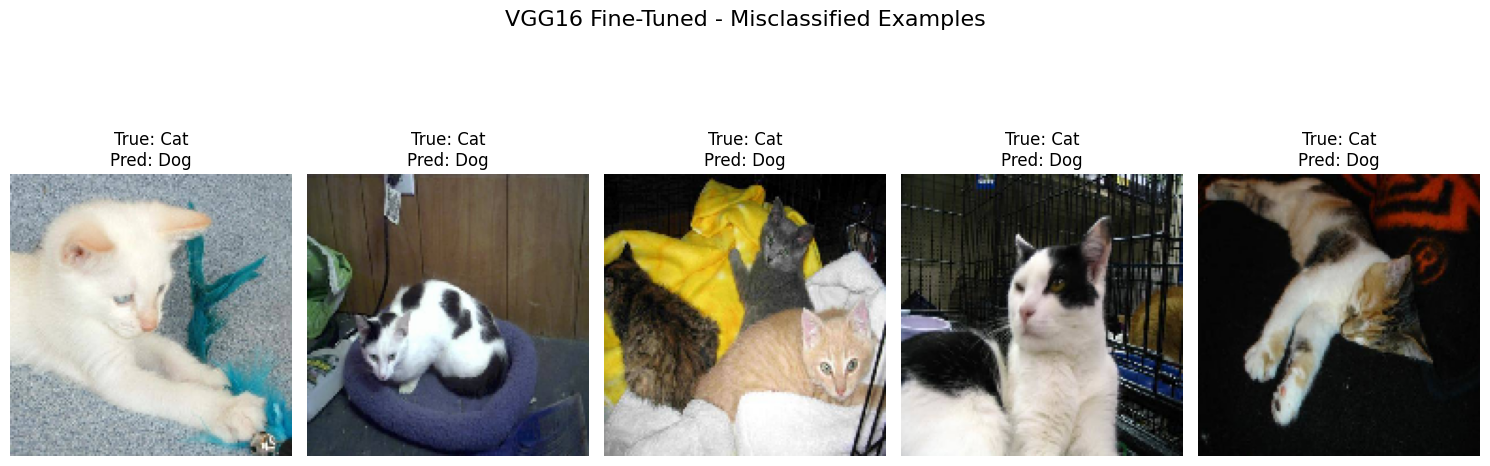

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image
def show_misclassified_images(predicted_labels, model_name):
    incorrect_indices = np.where(predicted_labels != true_labels)[0]
    print(f"{model_name} - Total misclassified: {len(incorrect_indices)}")

    if len(incorrect_indices) == 0:
        print("🎉 No misclassified images found!")
        return

    # Show first 5 misclassified images
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(incorrect_indices[:5]):
        # FIXED path
        img_path = os.path.join(val_gen_predict.directory, filenames[idx])

        # Load and show image
        img = image.load_img(img_path, target_size=(150, 150))
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        true_class = "Dog" if true_labels[idx] == 1 else "Cat"
        pred_class = "Dog" if predicted_labels[idx] == 1 else "Cat"
        plt.title(f"True: {true_class}\nPred: {pred_class}")

    plt.suptitle(f"{model_name} - Misclassified Examples", fontsize=16)
    plt.tight_layout()
    plt.show()
# Show 5 wrong predictions for Custom CNN
show_misclassified_images(cnn_labels, "Custom CNN")

# Show 5 wrong predictions for VGG16
show_misclassified_images(vgg_labels, "VGG16 Fine-Tuned")


##  Step 5: Final Conclusion

In this lab, we trained and compared two deep learning models for the Cats vs Dogs classification task:

###  Models:
- **Custom CNN (from scratch)**
- **VGG16 (fine-tuned on ImageNet)**

###  Key Observations:

| Metric        | Custom CNN | VGG16 Fine-Tuned |
|---------------|-------------|------------------|
| Accuracy      | 74.40%      | 89.90%           |
| Precision     | Moderate    | High             |
| Recall        | Moderate    | High             |
| F1-Score      | ~0.74       | ~0.90            |
| PR Curve AUC  | Lower       | Higher           |
| Misclassified | 256 images  | Much fewer       |

### Takeaways:
- **VGG16** clearly outperformed the custom model in all metrics.
- Transfer learning proved highly effective, even with a small dataset.
- Visual error analysis revealed subtle mistakes and provided qualitative insights.
- This project demonstrated the power of pre-trained models for faster and more accurate results in image classification tasks.

### Conclusion:
Fine-tuning a pre-trained model like VGG16 yields significantly better performance than training from scratch, especially when data is limited. This approach is recommended for real-world deployment scenarios.

